## MSA on Time Series Data

This is an example of how we can perform **"Multiperturbation Shapley value Analysis"** on a time series dataset to analyse the contribution of each node at each timestamp in some network. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
# ---------
from msapy import msa, plottings as pl
# ---------
from itertools import product

SEED = 42
RNG = np.random.default_rng(SEED)
pl.set_style()
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
FIG_PATH = "figures/timeseries/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### Data Simulation
We use sine waves to simulate the activity of each node. The activity of each node is wave of a certain frequency and amplitute

In [3]:
sampling_rate = 200
sampling_interval = 1/sampling_rate
timestamps = np.arange(0, 1, sampling_interval)

frequencies = np.arange(1, 10, 1.5)
amplitudes = np.arange(0.2, 2, 0.4)

amp_freq_pairs = np.array(list(map(list, product(amplitudes, frequencies))))

In [4]:
def generate_wave_data(amp_freq_pairs, timestamps, sampling_rate):
    frequencies = amp_freq_pairs[:, 1, None]
    amplitudes = amp_freq_pairs[:, 0, None]
    timestamps = np.broadcast_to(
        timestamps, (amplitudes.shape[0], sampling_rate))
    data = np.sin(2 * np.pi * timestamps * frequencies) * amplitudes
    return data

In [5]:
data = generate_wave_data(amp_freq_pairs, timestamps, sampling_rate)
elements = list(range(len(data)))

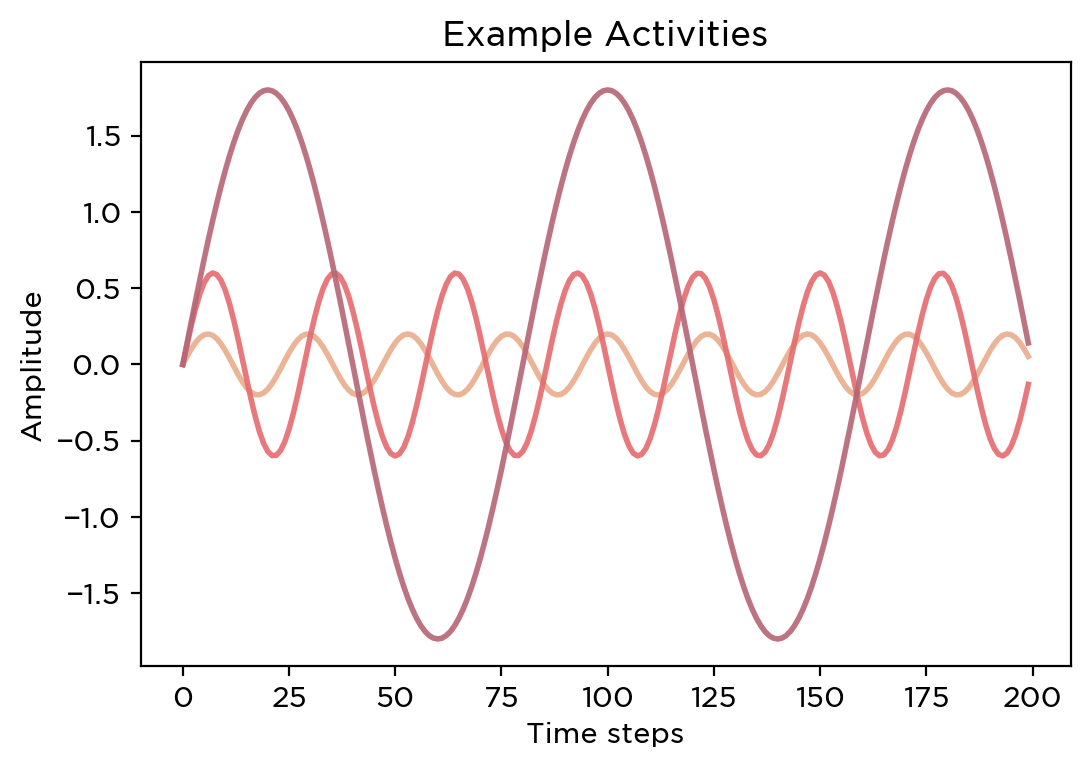

In [6]:
plt.figure(dpi=200)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)
plt.title("Example Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
#plt.legend()
plt.savefig(f"{FIG_PATH}example_activities.pdf",dpi=300,bbox_inches='tight')


For our first example, let's assume that the total activity is a linear function of the activity of each node. Therefore, let's say that the total activity of the network is the sum of activity of each node. And when we lesion some nodes, we remove the sum of their activites from the total sum.

In [7]:
def linear_score_function(complements):
    return data.sum(0) - data[complements, :].sum(0)

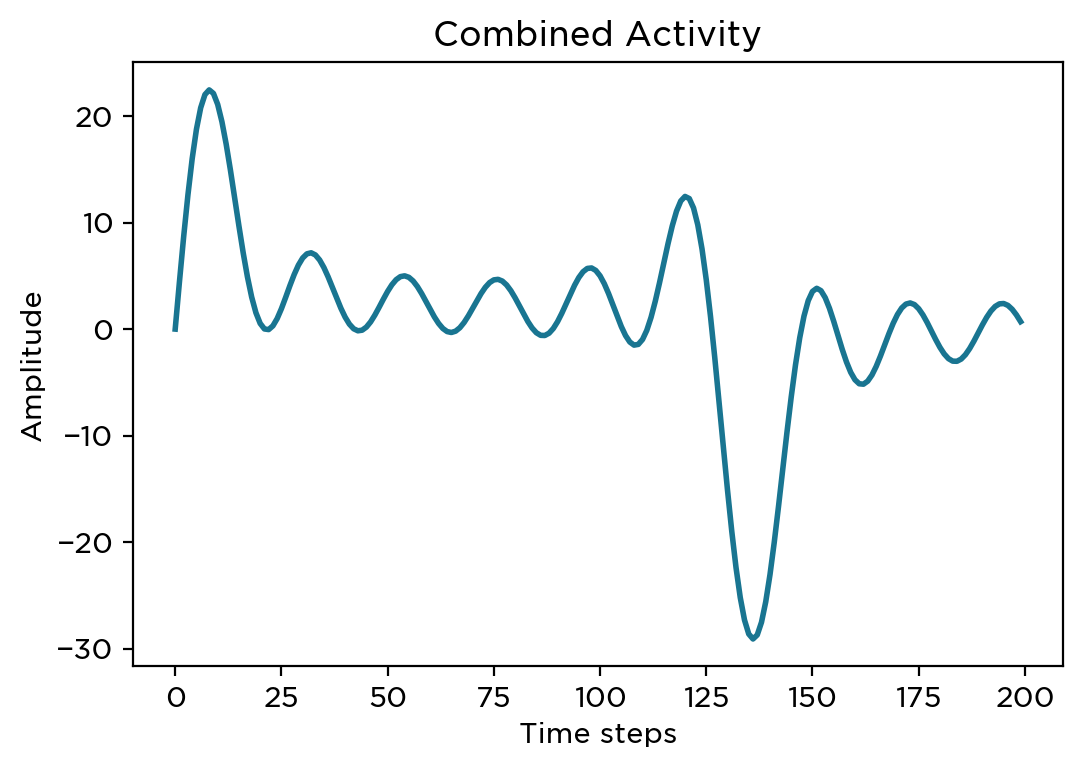

In [8]:
plt.figure(dpi=200)
plt.plot(linear_score_function([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("Combined Activity")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.savefig(f"{FIG_PATH}combined_activity.pdf",dpi=300,bbox_inches='tight');


#### MSA

In [9]:
shapley_table, _, _ = msa.interface(
    elements=elements,
    n_permutations=5_000,
    objective_function=linear_score_function,
    n_parallel_games=-1, #parallelized over all CPU cores
    rng=RNG)

Playing the games: 100%|██████████| 120658/120658 [00:01<00:00, 80708.72it/s]


After running the MSA algorithm for 5,000 permutations and 120658 trials, let's analyse the contributions of each node at each timestamp. The Shapley Table we got after running the MSA algorithm is a MultiIndex Pandas Dataframe. It has the contribution of each node for every permutation and for every timestamp.

In [10]:
shapley_table

0         1         2         3         4         5   \
     timestamp                                                               
0    0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     1          0.006282  0.015692  0.025067  0.034386  0.043629  0.052775   
     2          0.012558  0.031287  0.049738  0.067748  0.085156  0.101808   
     3          0.018822  0.046689  0.073625  0.099092  0.122581  0.143625   
     4          0.025067  0.061803  0.096351  0.127485  0.154103  0.175261   
...                  ...       ...       ...       ...       ...       ...   
4999 195       -0.031287  0.076537 -0.117557  0.152081 -0.178201  0.194474   
     196       -0.025067  0.061803 -0.096351  0.127485 -0.154103  0.175261   
     197       -0.018822  0.046689 -0.073625  0.099092 -0.122581  0.143625   
     198       -0.012558  0.031287 -0.049738  0.067748 -0.085156  0.101808   
     199       -0.006282  0.015692 -0.025067  0.034386 -0.043629  0.052775   

                      6         7         8         9   ...        20  \
     timestamp                                          ...             
0    0          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
     1          0.018846  0.047075  0.075200  0.103157  ...  0.175467   
     2          0.037674  0.093861  0.149214  0.203243  ...  0.348166   
     3          0.056465  0.140067  0.220875  0.297275  ...  0.515374   
     4          0.075200  0.185410  0.289052  0.382454  ...  0.674455   
...                  ...       ...       ...       ...  ...       ...   
4999 195       -0.093861  0.229610 -0.352671  0.456244  ... -0.822899   
     196       -0.075200  0.185410 -0.289052  0.382454  ... -0.674455   
     197       -0.056465  0.140067 -0.220875  0.297275  ... -0.515374   
     198       -0.037674  0.093861 -0.149214  0.203243  ... -0.348166   
     199       -0.018846  0.047075 -0.075200  0.103157  ... -0.175467   

                      21        22        23        24        25        26  \
     timestamp                                                               
0    0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     1          0.240701  0.305401  0.369422  0.056539  0.141226  0.225600   
     2          0.474233  0.596091  0.712658  0.113023  0.281582  0.447642   
     3          0.693642  0.858070  1.005377  0.169395  0.420202  0.662624   
     4          0.892394  1.078719  1.226829  0.225600  0.556231  0.867157   
...                  ...       ...       ...       ...       ...       ...   
4999 195        1.064568 -1.247409  1.361318 -0.281582  0.688830 -1.058013   
     196        0.892394 -1.078719  1.226829 -0.225600  0.556231 -0.867157   
     197        0.693642 -0.858070  1.005377 -0.169395  0.420202 -0.662624   
     198        0.474233 -0.596091  0.712658 -0.113023  0.281582 -0.447642   
     199        0.240701 -0.305401  0.369422 -0.056539  0.141226 -0.225600   

                      27        28        29  
     timestamp                                
0    0          0.000000  0.000000  0.000000  
     1          0.309472  0.392658  0.474971  
     2          0.609728  0.766403  0.916275  
     3          0.891826  1.103233  1.292627  
     4          1.147363  1.386924  1.577352  
...                  ...       ...       ...  
4999 195        1.368731 -1.603812  1.750266  
     196        1.147363 -1.386924  1.577352  
     197        0.891826 -1.103233  1.292627  
     198        0.609728 -0.766403  0.916275  
     199        0.309472 -0.392658  0.474971  

[1000000 rows x 30 columns]

We take the average of all permutations to calculate the shapley values for each node for each timestamp

In [11]:
shapley_values = shapley_table.groupby(level=1).mean()
shapley_values

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
timestamp,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006282,0.015692,0.025067,0.034386,0.043629,0.052775,0.018846,0.047075,0.075200,0.103157,...,0.175467,0.240701,0.305401,0.369422,0.056539,0.141226,0.225600,0.309472,0.392658,0.474971
2,0.012558,0.031287,0.049738,0.067748,0.085156,0.101808,0.037674,0.093861,0.149214,0.203243,...,0.348166,0.474233,0.596091,0.712658,0.113023,0.281582,0.447642,0.609728,0.766403,0.916275
3,0.018822,0.046689,0.073625,0.099092,0.122581,0.143625,0.056465,0.140067,0.220875,0.297275,...,0.515374,0.693642,0.858070,1.005377,0.169395,0.420202,0.662624,0.891826,1.103233,1.292627
4,0.025067,0.061803,0.096351,0.127485,0.154103,0.175261,0.075200,0.185410,0.289052,0.382454,...,0.674455,0.892394,1.078719,1.226829,0.225600,0.556231,0.867157,1.147363,1.386924,1.577352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.031287,0.076537,-0.117557,0.152081,-0.178201,0.194474,-0.093861,0.229610,-0.352671,0.456244,...,-0.822899,1.064568,-1.247409,1.361318,-0.281582,0.688830,-1.058013,1.368731,-1.603812,1.750266
196,-0.025067,0.061803,-0.096351,0.127485,-0.154103,0.175261,-0.075200,0.185410,-0.289052,0.382454,...,-0.674455,0.892394,-1.078719,1.226829,-0.225600,0.556231,-0.867157,1.147363,-1.386924,1.577352
197,-0.018822,0.046689,-0.073625,0.099092,-0.122581,0.143625,-0.056465,0.140067,-0.220875,0.297275,...,-0.515374,0.693642,-0.858070,1.005377,-0.169395,0.420202,-0.662624,0.891826,-1.103233,1.292627


Now we plot the contrbution we got after running MSA vs the activity of the node

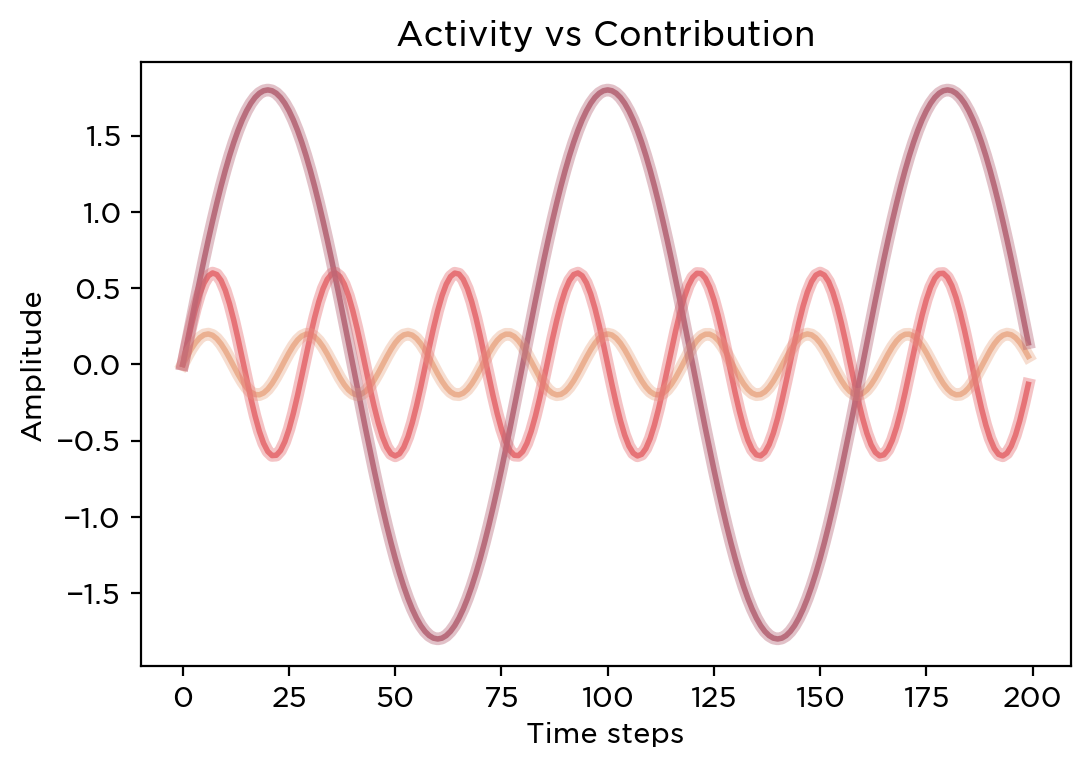

In [12]:
plt.figure(dpi=200)
plt.plot(data[5], label="node 5",c="#EAAC8B",lw=2,alpha=0.9)
plt.plot(data[10], label="node 10",c="#E56B6F",lw=2,alpha=0.9)
plt.plot(data[25], label="node 25",c="#B56576",lw=2,alpha=0.9)

plt.plot(shapley_values[5], label="Contribution #5",c="#EAAC8B",lw=4.5,alpha=0.4)
plt.plot(shapley_values[10], label="Contribution #10",c="#E56B6F",lw=4.5,alpha=0.4)
plt.plot(shapley_values[25], label="Contribution #25",c="#B56576",lw=4.5,alpha=0.4)
plt.title("Activity vs Contribution")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.savefig(f"{FIG_PATH}activity_vs_contribution.pdf",dpi=300,bbox_inches='tight')

The reason why we only see one wave is because both he activity of that node and the shapley value of that node is exactly the same for each timestamp and that's why they're overlapping in the plot. This is because the total activity of the nodes is a linear function of the activities of individual node. We can confirm that both the activities and shapley values are exactly the same by running the following code

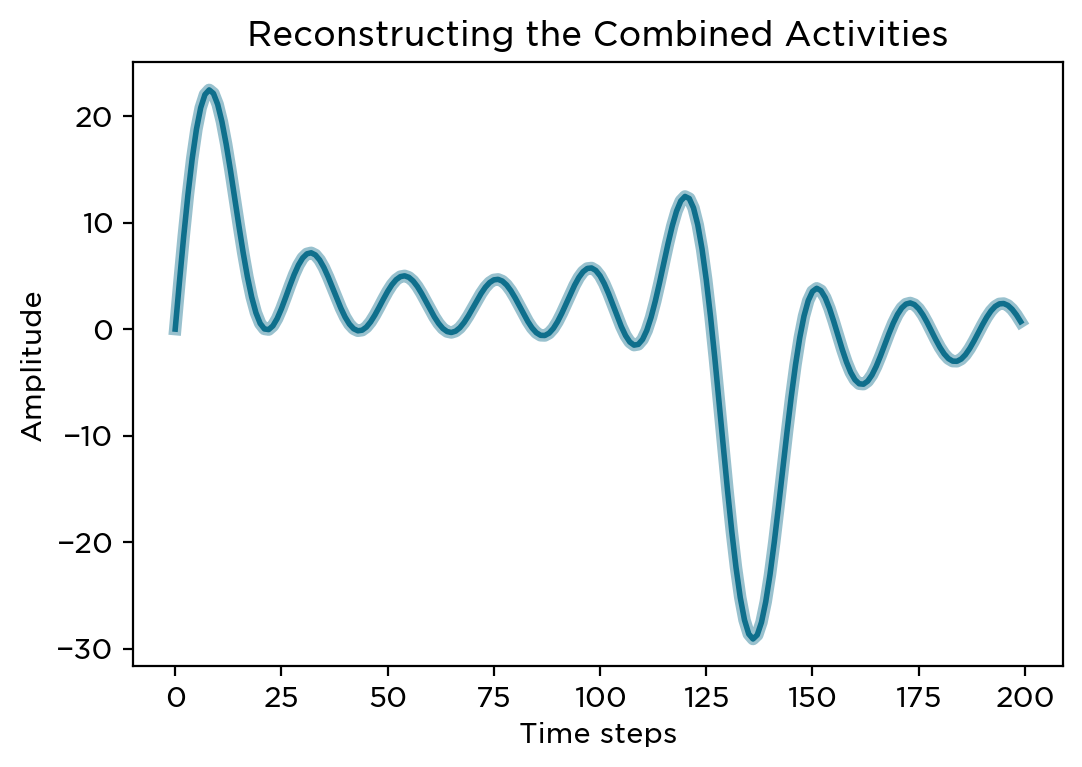

In [13]:
plt.figure(dpi=200)
plt.plot(linear_score_function([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(shapley_values.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.savefig(f"{FIG_PATH}reconstructing_easy.pdf",dpi=300,bbox_inches='tight')

In [14]:
np.allclose(shapley_values, data.T)

True

Okay, this is cool. But what will happen when the total activity of the network is not a linear function of the activities of individual neuron. To check this, we add a non-linearity of a `TanH` function and run the MSA again

In [15]:
non_linear_score_function = lambda x: np.tanh(linear_score_function(x))

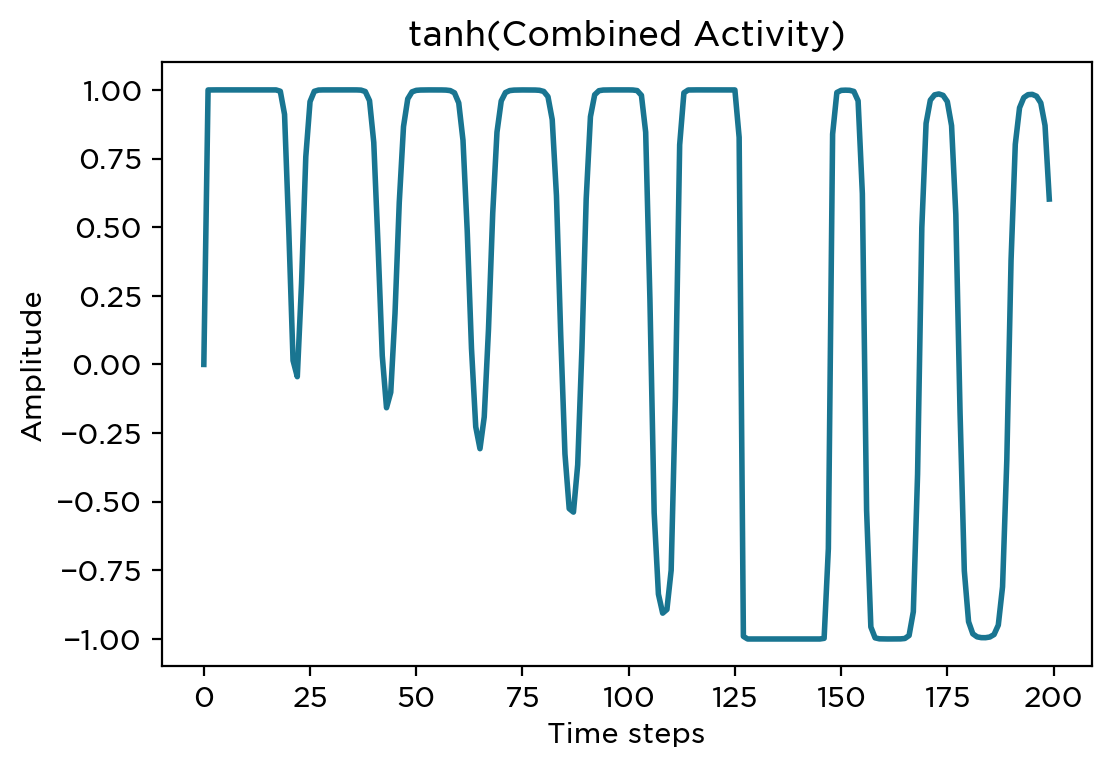

In [16]:
plt.figure(dpi=200)
plt.plot(non_linear_score_function([]),c=my_colors[0],lw=2,alpha=0.9)
plt.title("tanh(Combined Activity)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.savefig(f"{FIG_PATH}combined_activity_tanh.pdf",dpi=300,bbox_inches='tight');

In [17]:
shapley_table, _, _ = msa.interface(
    elements=elements,
    n_permutations=10_000,
    objective_function=non_linear_score_function,
    n_parallel_games=-1, #parallelized over all CPU cores
    rng=RNG)

shapley_values = shapley_table.groupby(level=1).mean()

Playing the games: 100%|██████████| 234089/234089 [00:04<00:00, 57696.41it/s]


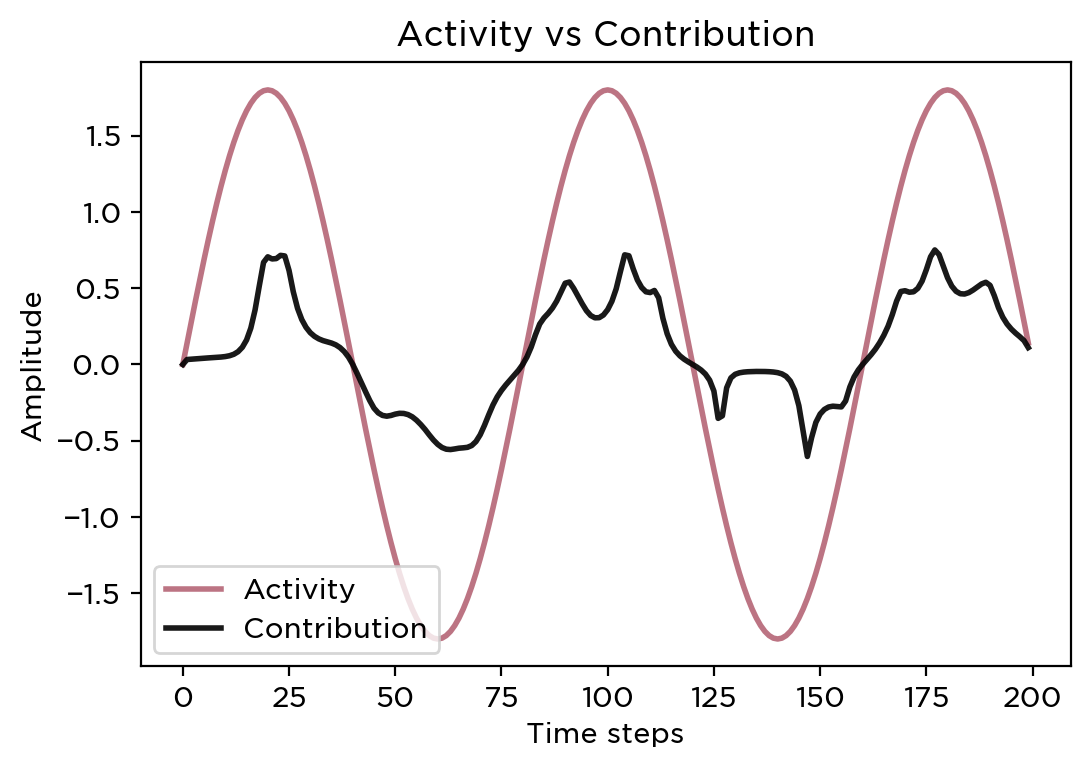

In [18]:
# node = 5
# plt.plot(timestamps, shapley_values[node], label = f"Shapley Value for node {node}")
# plt.plot(timestamps, data[node], label = f"activity of node {node}")
# plt.legend();

plt.figure(dpi=200)

plt.plot(data[25], label="Activity",c="#B56576",lw=2,alpha=0.9)

plt.plot(shapley_values[25], label="Contribution",c="k",lw=2,alpha=0.9)
plt.title("Activity vs Contribution")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend(loc="lower left")
plt.savefig(f"{FIG_PATH}activity_vs_contribution_tanh.pdf",dpi=300,bbox_inches='tight')

As we can see, in case of a non-linear function, the activities of the nodes is not exactly equal to their shapley values. But since the non-linearity was monotonic, we can observe that the activities and the shapley values of the nodes are very correlated to each other.
Now, let's try to plot the sum of shapley values of each node and the total activity of the network

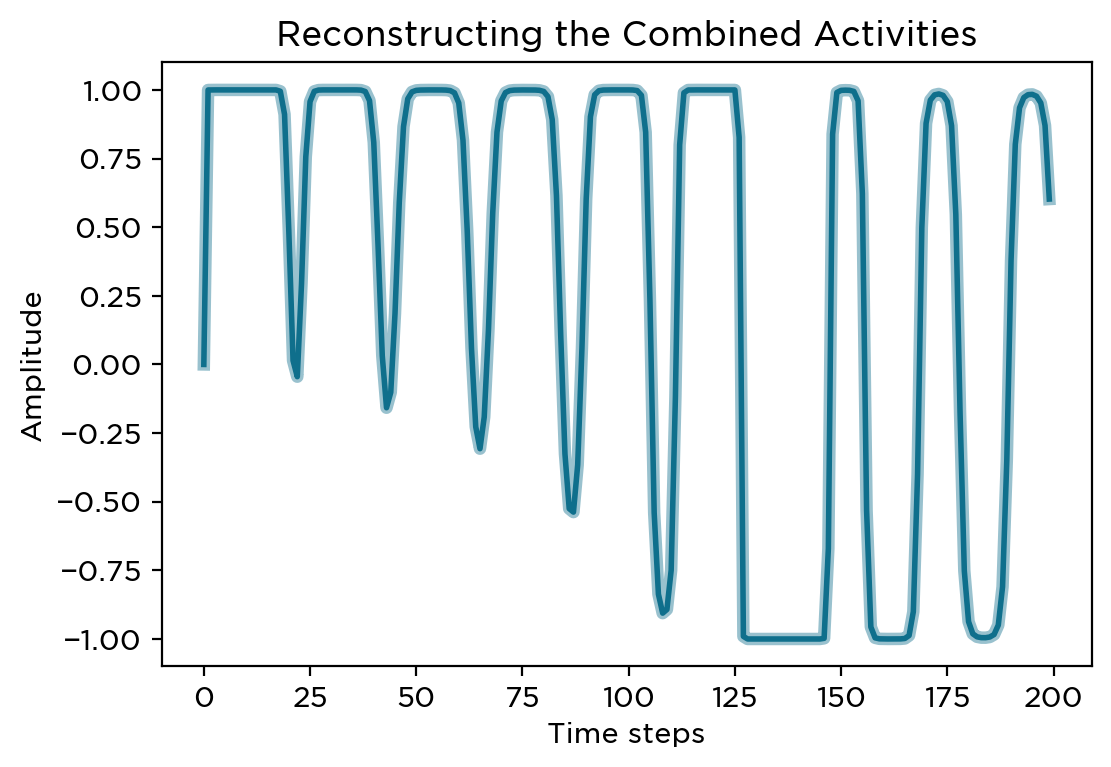

In [19]:
plt.figure(dpi=200)
plt.plot(non_linear_score_function([]),c=my_colors[0],lw=2,alpha=0.9)
plt.plot(shapley_values.sum(1),c=my_colors[0],lw=4.5,alpha=0.4)
plt.title("Reconstructing the Combined Activities")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.savefig(f"{FIG_PATH}reconstructing_hard.pdf",dpi=300,bbox_inches='tight')

The Combined Activity and the Sum of Shapley Values for all neurons are exactly the same and we can see them perfectly overlapping with each other. This is how we know that the MSA algorithm is working perfectly